Generate intial word embedding for headlines and description

The embedding is limited to a fixed vocabulary size (`vocab_size`) but
a vocabulary of all the words that appeared in the data is built.

In [1]:
FN = 'vocabulary-embedding'

In [2]:
seed=42

In [3]:
vocab_size = 40000

In [4]:
embedding_dim = 100

In [5]:
lower = False # dont lower case the text

# read tokenized headlines and descriptions

In [6]:
import cPickle as pickle
FN0 = 'tokens' # this is the name of the data file which I assume you already have
with open('data.pkl', 'rb') as fp:
    heads, desc, keywords = pickle.load(fp) # keywords are not used in this project

In [7]:
if lower:
    heads = [h.lower() for h in heads]

In [8]:
if lower:
    desc = [h.lower() for h in desc]

In [9]:
i=0
heads[i]

'Agent Cooper in Twin Peaks is the audience: once delighted, now disintegrating'

In [10]:
desc[i]

'      And never more so than in Showtime\xe2\x80\x99s new series revival Some spoilers ahead through episode 4 of season 3 of Twin Peaks. On May 21st Showtime brought back David Lynch\xe2\x80\x99s groundbreaking TV series Twin Peaks and fulfilled a prophecy in the process. In the second season finale back in 1991 the spirit of series-defining murder victim Laura Palmer told FBI special agent and series protagonist Dale Cooper \xe2\x80\x9cI\xe2\x80\x99ll see you again in 25 years.\xe2\x80\x9d That clip plays again in the first episode of Lynch\xe2\x80\x99s Twin Peaks revival as a reminder that decades have in fact gone by Laura\xe2\x80\x99s promise has been carried out and a series canceled mid-story is back on the air.A lot has changed in 25 years. The original cast members who are mostly back on board have all aged heavily and visibly. Many of the characters have moved on in life getting new jobs forming families or taking up new obsessions. But in the opening episode Dale Cooper was

In [11]:
keywords[i]

TypeError: 'NoneType' object has no attribute '__getitem__'

In [12]:
len(heads),len(set(heads))

(96543, 88093)

In [13]:
len(desc),len(set(desc))

(96543, 88912)

# build vocabulary

In [14]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return vocab, vocabcount

In [15]:
vocab, vocabcount = get_vocab(heads+desc)

most popular tokens

In [16]:
print vocab[:50]
print '...',len(vocab)

['the', 'to', 'of', 'a', 'and', 'in', 'that', 'for', 'is', 'on', 'was', 'with', 'as', 'The', 'he', 'it', 'at', 'his', 'have', 'be', 'from', 'are', 'by', 'has', 'not', 'I', 'an', 'said', 'who', 'Trump', '\xe2\x80\x94', 'this', 'they', 'about', 'or', 'had', 'their', 'but', 'will', 'you', 'were', 'would', 'more', 'been', 'her', 'one', 'she', 'we', 'people', 'which']
... 1322508


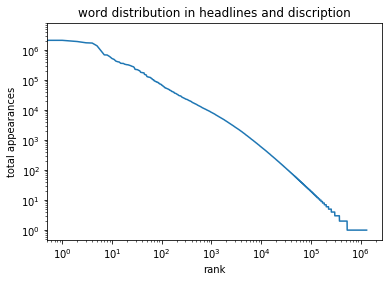

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

always nice to see [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law)

# Index words

In [18]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [19]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.iteritems())

    return word2idx, idx2word

In [20]:
word2idx, idx2word = get_idx(vocab, vocabcount)

# Word Embedding

## read GloVe

In [21]:
fname = 'glove.6B.%dd.txt'%embedding_dim
import os
import keras
import numpy as np
import tensorflow as tf
datadir_base = os.path.expanduser(os.path.join('~', '.keras'))
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
datadir = os.path.join(datadir_base, 'datasets')
glove_name = os.path.join(datadir, fname)
if not os.path.exists(glove_name):
    path = 'glove.6B.zip'
    path = keras.utils.get_file(path, origin="http://nlp.stanford.edu/data/glove.6B.zip")
    !unzip {datadir}/{path}

Using TensorFlow backend.


unzip:  cannot find or open /Users/danemichaelhankamer/.keras/datasets//Users/danemichaelhankamer/.keras/datasets/glove.6B.zip, /Users/danemichaelhankamer/.keras/datasets//Users/danemichaelhankamer/.keras/datasets/glove.6B.zip.zip or /Users/danemichaelhankamer/.keras/datasets//Users/danemichaelhankamer/.keras/datasets/glove.6B.zip.ZIP.


In [22]:
glove_n_symbols = !wc -l {"glove.6B.100d.txt"}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

400000

In [24]:
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open("glove.6B.100d.txt", 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = map(float,l[1:])
        i += 1
glove_embedding_weights *= globale_scale

In [25]:
glove_embedding_weights.std()

0.04081572760019029

In [26]:
for w,i in glove_index_dict.iteritems():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

## embedding matrix

use GloVe to initialize embedding matrix

In [27]:
import numpy as np

# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print 'random-embedding/glove scale', scale, 'std', embedding.std()

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print 'number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size)

random-embedding/glove scale 0.0706949139514209 std 0.04081382495746382
number of tokens, in small vocab, found in glove and copied to embedding 28629 0.715725


lots of word in the full vocabulary (word2idx) are outside `vocab_size`.
Build an alterantive which will map them to their closest match in glove but only if the match
is good enough (cos distance above `glove_thr`)

In [28]:
glove_thr = 0.5

In [29]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

for every word outside the embedding matrix find the closest word inside the mebedding matrix.
Use cos distance of GloVe vectors.

Allow for the last `nb_unknown_words` words inside the embedding matrix to be considered to be outside.
Dont accept distances below `glove_thr`

In [30]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.iteritems():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print '# of glove substitutes found', len(glove_match)

# of glove substitutes found 112740


manually check that the worst substitutions we are going to do are good enough

In [31]:
for orig, sub, score in glove_match[-10:]:
    print score, orig,'=>', idx2word[sub]

0.5000164127769458 Modigliani => Warhol
0.5000117912758282 Salvi => Allred
0.5000113658688605 Colleyville => Calabasas
0.5000089661535665 Vilma => Pineda
0.5000085715859812 Philo => Cyrus
0.5000069905641444 Terada => Kislyak
0.5000059469811271 colonizing => migrating
0.5000056910428538 sniped => bristled
0.5000055595011661 cheapskate => dude
0.5000037989997332 Maia => Joanna


build a lookup table of index of outside words to index of inside words

In [32]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

# Data

In [33]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]
len(Y)

96543

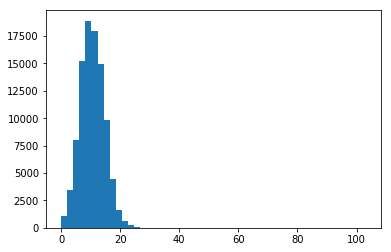

In [34]:
plt.hist(map(len,Y),bins=50);

In [35]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)

96543

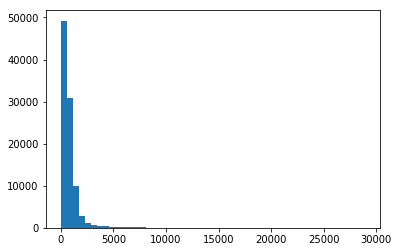

In [36]:
plt.hist(map(len,X),bins=50);

In [37]:
import cPickle as pickle
with open('data/%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [38]:
import cPickle as pickle
with open('data/%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)